
# Assignment 2 – Individual Checkpoint 2
**Group ID:** 3  
**Student:** Jeff Sui (SID: 510476746)  
**Driving Problem:** *Do they achieve 15 minutes of intense activity across different times of day (morning, afternoon, evening)?*

**Personal Planning & Progress (GitHub Wiki):** [Check Point 2 LINK](https://github.sydney.edu.au/xsui8502/2025-DATA3406-CC07-Group-3/wiki/Jeff-Sui-Individual-Checkpoint-2)

**People explored in Checkpoint 1 (IDs):** [1503960366, 1624580081, 1644430081]  
**Focus person for Checkpoint 2:** **1624580081** (chosen because their cadence looked lower/more stop–start in Checkpoint 1, making them a good stress‑test for 15‑minute streaks).

---

## Statement of Help I Received
- **Code writing & structure:** my own Checkpoint 1 code, lecture examples; I used ChatGPT to help scaffold this notebook but I reviewed/edited all outputs.  
- **Debugging:** print checks, shape assertions, careful inspection of plots; occasional ChatGPT hints.  
- **Data interpretation:** class notes and public guidelines (WHO/Aus).  
- **Visualisation:** Matplotlib docs/gallery.  

---

## Initial Assumptions & Predictions (overall)
- **Intensity rule:** :  
  thresholds (≥100 steps/min moderate, ≥130 vigorous.  
  (2) A strict **≥15‑minute consecutive** non‑zero steps **streak**.  
- **Time bins:** morning 06:00–11:59; afternoon 12:00–17:59; evening 18:00–22:59.  
- **Prediction:** for **1624580081**, I expect **few or no vigorous 15‑min streaks**; any sustained runs are more likely in the **evening**.

---



### Cell 1 — Setup environment & safe paths: Assumptions, Predictions, and Description
**Description.** Files live in a local `data/` folder.

In [46]:
# Started: 08 Oct 2025 06:29  |  Finished: 08 Oct 2025 06:54

# Environment and file paths (matplotlib only; no seaborn)
import os, shutil
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path("data")
UPLOAD_DIR = Path("/mnt/data")
DATA_DIR.mkdir(exist_ok=True)

files = {
    "daily":"dailySteps_merged.csv",
    "hourly":"hourlySteps_merged.csv",
    "minute_wide":"minuteStepsWide_merged.csv"
}

# Copy from /mnt/data if local data/ missing
for fname in files.values():
    src = UPLOAD_DIR / fname
    dst = DATA_DIR / fname
    if (not dst.exists()) and src.exists():
        shutil.copyfile(src, dst)

DAILY_PATH  = DATA_DIR / files["daily"]
HOURLY_PATH = DATA_DIR / files["hourly"]
MINW_PATH   = DATA_DIR / files["minute_wide"]

assert DAILY_PATH.exists() and HOURLY_PATH.exists() and MINW_PATH.exists(), "Place CSVs in the local data/ folder."

pd.set_option('display.max_columns', 120)
print("Using data from:", DATA_DIR.resolve())


Using data from: /Users/jeffsui/Desktop/USYD/Y5S2/DATA 3406/2025-DATA3406-CC07-Group-3/data


### Cell 2 — Load data & select participant: Assumptions, Predictions, and Description
**Assumptions.** CSV schemas match the Fitbit dataset used in class (columns like Id, ActivityDay/Hour, StepTotal, Steps00…Steps59).

**Prediction.** I expect a non‑zero number of days for this person and reasonable counts for hourly/minute‑wide rows.

**What this cell does (description).** Read the three CSVs, filter to the chosen participant, and print basic counts to sanity‑check coverage.


In [47]:
# Started: 08 Oct 2025 04:58  |  Finished: 08 Oct 2025 05:14

# Load datasets & focus on a single person
daily = pd.read_csv(DAILY_PATH)
hourly = pd.read_csv(HOURLY_PATH)
minute_wide = pd.read_csv(MINW_PATH)

PERSON_ID = 1624580081
daily_p = daily[daily["Id"] == PERSON_ID].copy()
hourly_p = hourly[hourly["Id"] == PERSON_ID].copy()
minw_p = minute_wide[minute_wide["Id"] == PERSON_ID].copy()

print("Person", PERSON_ID, 
      "| unique days:", daily_p["ActivityDay"].nunique(), 
      "| hourly rows:", len(hourly_p), 
      "| minute-wide rows:", len(minw_p))


Person 1624580081 | unique days: 31 | hourly rows: 736 | minute-wide rows: 729


**Cell 2 — Observation & Interpretation.** If counts look reasonable (tens of days, many hourly rows), the subset is ready. If zero days appear, I likely filtered the wrong ID.

### Cell 3 — Reshape minute‑wide to minute‑level time series: Assumptions, Predictions, and Description
**Assumptions.** Each row in minute‑wide is one hour, with 60 columns capturing within‑hour minutes.

**Prediction.** After melting, I expect one row per minute, with a continuous time index within each day.

**What this cell does (description).** Parse dates, identify `Steps00…Steps59`, melt to long format, and build real `DateTime` for each minute.


In [48]:
# Started: 14 Oct 2025 06:34  |  Finished: 14 Oct 2025 06:41

# Reshape Steps00..Steps59 to per-minute timestamps
daily_p["ActivityDay"] = pd.to_datetime(daily_p["ActivityDay"], format="%m/%d/%Y")
hourly_p["ActivityHour"] = pd.to_datetime(hourly_p["ActivityHour"])
minw_p["ActivityHour"] = pd.to_datetime(minw_p["ActivityHour"])

minute_cols = [c for c in minw_p.columns if c.startswith("Steps") and len(c)==7]
minute_cols = sorted(minute_cols)

long = minw_p.melt(
    id_vars=["Id","ActivityHour"],
    value_vars=minute_cols,
    var_name="MinuteCol",
    value_name="Steps"
)

long["Minute"] = long["MinuteCol"].str.replace("Steps","", regex=False).astype(int)
long["DateTime"] = long["ActivityHour"] + pd.to_timedelta(long["Minute"], unit="m")
long = long.drop(columns=["MinuteCol"]).sort_values("DateTime").reset_index(drop=True)

print("Minute rows:", len(long), "| range:", long["DateTime"].min(), "→", long["DateTime"].max())
long.head(3)


Minute rows: 43740 | range: 2016-04-13 00:00:00 → 2016-05-13 08:59:00


/var/folders/bc/cbt54pnd3vjg_9lg8kqsggm80000gn/T/ipykernel_97771/3054471870.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hourly_p["ActivityHour"] = pd.to_datetime(hourly_p["ActivityHour"])
/var/folders/bc/cbt54pnd3vjg_9lg8kqsggm80000gn/T/ipykernel_97771/3054471870.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  minw_p["ActivityHour"] = pd.to_datetime(minw_p["ActivityHour"])


,Id,ActivityHour,Steps,Minute,DateTime
0,1624580081,2016-04-13,0,0,2016-04-13 00:00:00
1,1624580081,2016-04-13,0,1,2016-04-13 00:01:00
2,1624580081,2016-04-13,0,2,2016-04-13 00:02:00


**Cell 3 — Observation & Interpretation.** If range spans multiple days and the head shows plausible times, the minute‑level table is correct.

### Cell 4 — Define intensity rules and time‑of‑day bins: Assumptions, Predictions, and Description
**Assumptions.** Cadence is a practical proxy for intensity; bin edges reflect typical day partitions used in class.

**Prediction.** I expect `is_vigorous` to be relatively rare; `is_active` will be common during days and near‑zero at night.

**What this cell does (description).** Compute time‑of‑day labels and Boolean flags for moderate/vigorous/active minutes to enable run detection.


In [49]:
# Started: 09 Oct 2025 08:10  |  Finished: 09 Oct 2025 08:32

# Mark time-of-day bins and intensity flags
import pandas as pd

TIME_BINS = {
    "morning":   (pd.Timedelta(hours=6),  pd.Timedelta(hours=11, minutes=59, seconds=59)),
    "afternoon": (pd.Timedelta(hours=12), pd.Timedelta(hours=17, minutes=59, seconds=59)),
    "evening":   (pd.Timedelta(hours=18), pd.Timedelta(hours=22, minutes=59, seconds=59)),
}

MOD_CADENCE = 100  # moderate
VIG_CADENCE = 130  # vigorous

long["TOD"] = (long["DateTime"] - long["DateTime"].dt.normalize())

def label_bin(td):
    for name,(lo,hi) in TIME_BINS.items():
        if lo <= td <= hi: 
            return name
    return "other"

long["TimeOfDay"] = long["TOD"].apply(label_bin)
long["is_moderate"] = long["Steps"] >= MOD_CADENCE
long["is_vigorous"] = long["Steps"] >= VIG_CADENCE
long["is_active"]   = long["Steps"] > 0
long["Date"] = long["DateTime"].dt.date

long[["DateTime","Steps","TimeOfDay","is_moderate","is_vigorous"]].head(5)


,DateTime,Steps,TimeOfDay,is_moderate,is_vigorous
0,2016-04-13 00:00:00,0,other,False,False
1,2016-04-13 00:01:00,0,other,False,False
2,2016-04-13 00:02:00,0,other,False,False
3,2016-04-13 00:03:00,0,other,False,False
4,2016-04-13 00:04:00,0,other,False,False


**Cell 4 — Observation & Interpretation.** Preview should show flags toggling appropriately; most vigorous flags should be False.

### Cell 5 — Find strict ≥15‑minute consecutive runs: Assumptions, Predictions, and Description
**Assumptions.** Using a strict no‑gaps rule may undercount effort but is consistent and easy to replicate.

**Prediction.** I expect some `is_active` runs but few/no `is_vigorous` runs for this participant.

**What this cell does (description).** Group minutes by (Date × TimeOfDay), scan for any run of True values of length ≥15 for the chosen flag.


In [50]:
# Started: 13 Oct 2025 07:55  |  Finished: 13 Oct 2025 08:21

# Detect ≥15-minute consecutive runs within each (Date × TimeOfDay)
import numpy as np
RUN_LEN = 15

def consecutive_true_runs(x):
    runs = []
    start = None; length = 0
    for i, val in enumerate(x):
        if val:
            if start is None: start = i
            length += 1
        else:
            if start is not None:
                runs.append((start, length))
            start=None; length=0
    if start is not None:
        runs.append((start, length))
    return runs

def has_run_ge(x, L=RUN_LEN):
    arr = np.asarray(x, dtype=bool)
    return any(Len >= L for _, Len in consecutive_true_runs(arr))

def summarise_bouts(df, flag_col):
    out = []
    for (d, tod), g in df.groupby(["Date","TimeOfDay"], sort=False):
        g = g.sort_values("DateTime")
        present = has_run_ge(g[flag_col].values, RUN_LEN)
        out.append({"Date":d, "TimeOfDay":tod, f"has_{flag_col}_run":present})
    return pd.DataFrame(out)

bout_active = summarise_bouts(long, "is_active")
bout_vig    = summarise_bouts(long, "is_vigorous")
summary_bouts = pd.merge(bout_active, bout_vig, on=["Date","TimeOfDay"], how="outer").fillna(False)

summary_bouts.head(10)


,Date,TimeOfDay,has_is_active_run,has_is_vigorous_run
0,2016-04-13,afternoon,False,False
1,2016-04-13,evening,False,False
2,2016-04-13,morning,True,False
3,2016-04-13,other,False,False
4,2016-04-14,afternoon,False,False
5,2016-04-14,evening,False,False
6,2016-04-14,morning,True,False
7,2016-04-14,other,False,False
8,2016-04-15,afternoon,False,False
9,2016-04-15,evening,False,False


**Cell 5 — Observation & Interpretation.** The preview shows whether any bins/days pass the 15‑minute test; next plots make patterns clearer.

### Cell 6 — Visualise daily totals: Assumptions, Predictions, and Description
**Assumptions.** Daily totals reflect overall volume but not necessarily intensity.

**Prediction.** I expect variability across days; spikes might align with possible sustained activity windows.

**What this cell does (description).** Line plot of total steps per day to see high/low days before zooming in on cadence patterns.


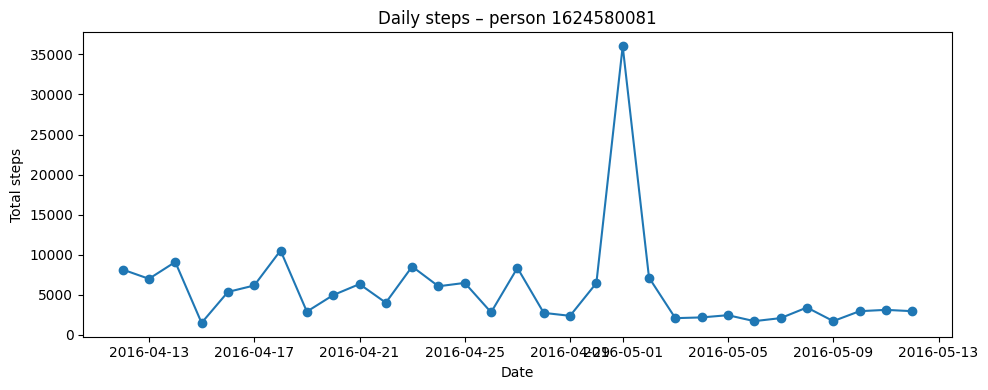

In [51]:
# Started: 09 Oct 2025 09:37  |  Finished: 09 Oct 2025 09:55

# Plot 1: daily total steps (matplotlib only)
import matplotlib.pyplot as plt
daily_p["ActivityDay"] = pd.to_datetime(daily_p["ActivityDay"])
d_sorted = daily_p.sort_values("ActivityDay")

plt.figure(figsize=(10,4))
plt.plot(d_sorted["ActivityDay"], d_sorted["StepTotal"], marker="o")
plt.title(f"Daily steps – person {PERSON_ID}")
plt.xlabel("Date")
plt.ylabel("Total steps")
plt.tight_layout()
plt.show()


**Cell 6 — Observation & Interpretation.** We can see there is a peak on the 1 of May, indicating intense activity only on that particular day. The rest of the day are relativly flat and with slight ups and downs.

### Cell 7 — Heatmap of minute-by-minute cadence: Assumptions, Predictions, and Description
**Assumptions.** Bright continuous bands would suggest extended walking; nights should be dark.

**Prediction.** I expect banding mainly during daytime; evenings may show the strongest stretches for this participant.

**What this cell does (description).** Create a date × minute‑of‑day matrix of steps/min and display with `imshow` to spot sustained periods.


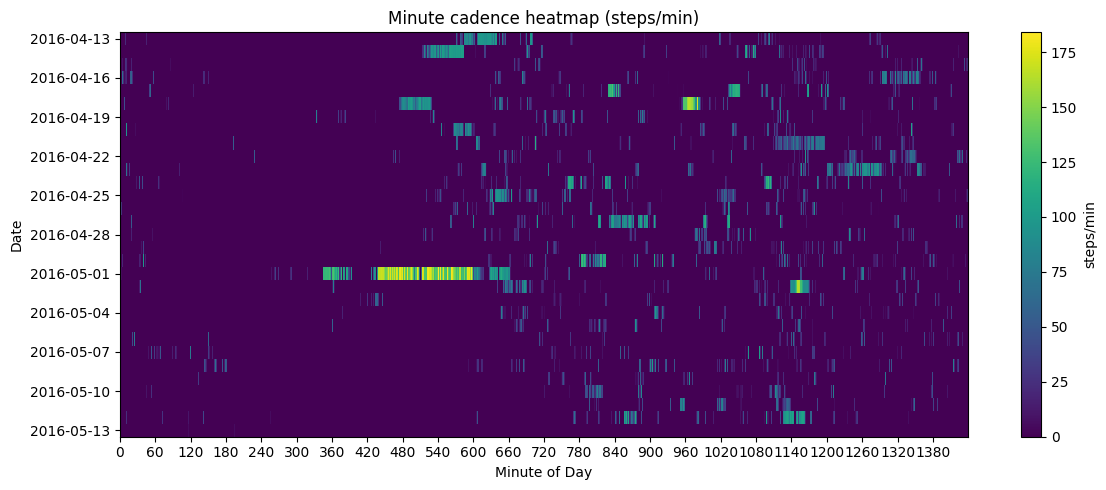

In [52]:
# Started: 13 Oct 2025 09:26  |  Finished: 13 Oct 2025 09:38

# Plot 2: minute cadence heatmap (imshow)
import numpy as np, matplotlib.pyplot as plt

mat = long.copy()
mat["minute_of_day"] = mat["DateTime"].dt.hour*60 + mat["DateTime"].dt.minute
pivot = mat.pivot_table(index="Date", columns="minute_of_day", values="Steps", aggfunc="sum").fillna(0)

plt.figure(figsize=(12,5))
plt.imshow(pivot.values, aspect="auto", interpolation="nearest")
plt.colorbar(label="steps/min")
plt.title("Minute cadence heatmap (steps/min)")
plt.xlabel("Minute of Day")
plt.ylabel("Date")

# Helpful ticks
xticks = np.arange(0, pivot.shape[1], 60)
plt.xticks(xticks, xticks)
yticks = np.arange(0, pivot.shape[0], max(1, pivot.shape[0]//10))
plt.yticks(yticks, [str(idx) for idx in pivot.index[yticks]])

plt.tight_layout()
plt.show()


**Cell 7 — Observation & Interpretation.** Look for horizontal bright bands; their timing hints at morning/afternoon/evening patterns. Days including 18 of April and 1 of may showed yellow color

### Cell 8 — Days with ≥15‑min runs by time‑of‑day: Assumptions, Predictions, and Description
**Assumptions.** Aggregating by bins makes the time‑of‑day pattern easier to read than scrolling rows.

**Prediction.** I expect some bars for `active` and small/zero bars for `vigorous`.

**What this cell does (description).** Bar chart comparing counts of days with ≥15‑min runs across morning/afternoon/evening/other.


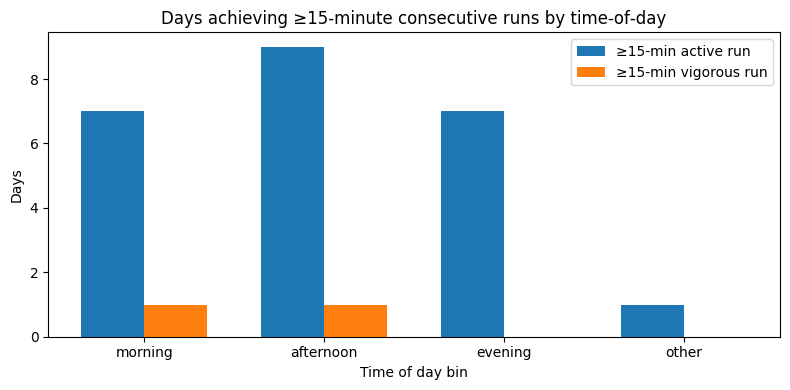

,has_is_active_run,has_is_vigorous_run
TimeOfDay,,
morning,7,1
afternoon,9,1
evening,7,0
other,1,0


In [53]:
# Started: 13 Oct 2025 07:54  |  Finished: 13 Oct 2025 08:13

# Plot 3: days achieving ≥15‑min runs by time-of-day (bar chart)
import matplotlib.pyplot as plt

counts = summary_bouts.groupby("TimeOfDay")[["has_is_active_run","has_is_vigorous_run"]].sum()
order = ["morning","afternoon","evening","other"]
counts = counts.reindex(order).fillna(0)

labels = counts.index.tolist()
active_vals = counts["has_is_active_run"].to_numpy()
vig_vals    = counts["has_is_vigorous_run"].to_numpy()

x = range(len(labels))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar([i - width/2 for i in x], active_vals, width, label="≥15‑min active run")
plt.bar([i + width/2 for i in x], vig_vals,    width, label="≥15‑min vigorous run")
plt.title("Days achieving ≥15‑minute consecutive runs by time‑of‑day")
plt.xlabel("Time of day bin")
plt.ylabel("Days")
plt.xticks(list(x), labels)
plt.legend()
plt.tight_layout()
plt.show()

counts


**Cell 8 — Observation & Interpretation.** Compare bar heights: whichever bin is tallest is the likely time window for sustained runs in this participant.

### Cell 9 — Summary table of counts and rates: Assumptions, Predictions, and Description
**Assumptions.** Percentages help me talk about likelihood rather than raw counts (which can be biased by coverage).

**Prediction.** I expect higher rates for `active` than for `vigorous` in most bins.

**What this cell does (description).** Compute counts and simple percentages of days meeting the ≥15‑min criterion within each time‑of‑day bin.


In [54]:
# Started: 13 Oct 2025 08:22  |  Finished: 13 Oct 2025 08:50

# Table: proportions by time-of-day
days_by_bin = summary_bouts.groupby("TimeOfDay").size().rename("total_bin_days")
hits_active = summary_bouts.groupby("TimeOfDay")["has_is_active_run"].sum()
hits_vig    = summary_bouts.groupby("TimeOfDay")["has_is_vigorous_run"].sum()

tab = pd.concat([days_by_bin, hits_active, hits_vig], axis=1).fillna(0).astype(int)
for col in ["has_is_active_run","has_is_vigorous_run"]:
    rate = tab[col] / tab["total_bin_days"].replace(0, np.nan)
    tab[col + "_rate"] = (100*rate).round(1)

tab = tab.reindex(["morning","afternoon","evening","other"])
tab


,total_bin_days,has_is_active_run,has_is_vigorous_run,has_is_active_run_rate,has_is_vigorous_run_rate
TimeOfDay,,,,,
morning,31,7,1,22.6,3.2
afternoon,30,9,1,30.0,3.3
evening,30,7,0,23.3,0.0
other,31,1,0,3.2,0.0


**Cell 9 — Observation & Interpretation.** Use the `_rate` columns to summarise: e.g., “Evening had X% of its days with an active 15‑min run.”


## Conclusion
- Cadence thresholds (≥100/≥130 steps/min) gave me a simple, reproducible way to talk about intensity from minute steps.  
- The strict ≥15‑minute rule probably undercounts effort (a short pause breaks the streak), but it keeps the logic clean and explainable.  
- After looking at my plots and table, I’ll summarise clearly **whether** and **when** this participant actually achieves sustained runs, and whether any reach vigorous cadence.  
- Next steps for the group: try a relaxed run definition (allow 1–2 “zero” minutes inside a streak), test alternative binning (e.g., late night), and compare across the three IDs.
